In [1]:
%matplotlib inline
from keras import applications
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras import optimizers

In [2]:
img_size = 256
_lambda = 0.01

In [3]:
data = np.load('processed_val_images.npy')
labels = np.load('processed_val_labels.npy')

print(data.shape)
print(labels.shape)

(2815, 256, 256, 3)
(2815,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, random_state = 20)

nb_classes = 2
y_train = np.array(y_train)
y_test = np.array(y_test)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print("Training label shape", Y_train.shape)
print("Testing label shape", Y_test.shape)

Training matrix shape (2252, 256, 256, 3)
Testing matrix shape (563, 256, 256, 3)
Training label shape (2252, 2)
Testing label shape (563, 2)


In [15]:
model = applications.VGG16(weights="imagenet", include_top=False, input_shape = (img_size, img_size, 3))

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [17]:
top_model = Sequential()

top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

In [18]:
new_model = Sequential() #new model
for layer in model.layers: 
    new_model.add(layer)
    
new_model.add(top_model) # now this works

In [19]:
for layer in model.layers[:21]:
    layer.trainable = False

In [23]:
adam = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.7, nesterov=True)
new_model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

In [24]:
m1 = new_model.fit(X_train, Y_train, batch_size=16, epochs=32, verbose=2)

Epoch 1/32
141/141 - 359s - loss: 0.6548 - accuracy: 0.6159
Epoch 2/32
141/141 - 356s - loss: 0.6572 - accuracy: 0.6092
Epoch 3/32
141/141 - 352s - loss: 0.6509 - accuracy: 0.6115
Epoch 4/32
141/141 - 360s - loss: 0.6462 - accuracy: 0.6186
Epoch 5/32
141/141 - 366s - loss: 0.6468 - accuracy: 0.6306
Epoch 6/32
141/141 - 372s - loss: 0.6404 - accuracy: 0.6474
Epoch 7/32
141/141 - 370s - loss: 0.6431 - accuracy: 0.6328
Epoch 8/32
141/141 - 354s - loss: 0.6395 - accuracy: 0.6394
Epoch 9/32
141/141 - 373s - loss: 0.6418 - accuracy: 0.6248
Epoch 10/32
141/141 - 369s - loss: 0.6369 - accuracy: 0.6319
Epoch 11/32
141/141 - 356s - loss: 0.6360 - accuracy: 0.6399
Epoch 12/32
141/141 - 349s - loss: 0.6287 - accuracy: 0.6536
Epoch 13/32
141/141 - 366s - loss: 0.6238 - accuracy: 0.6505
Epoch 14/32
141/141 - 370s - loss: 0.6280 - accuracy: 0.6532
Epoch 15/32
141/141 - 385s - loss: 0.6215 - accuracy: 0.6496
Epoch 16/32
141/141 - 381s - loss: 0.6197 - accuracy: 0.6639
Epoch 17/32
141/141 - 373s - loss

In [25]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    #plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.ylim(0, 1)    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

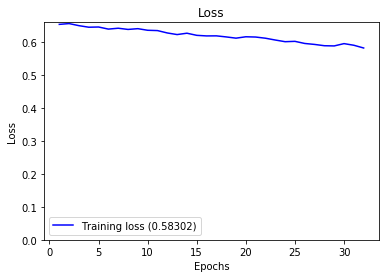

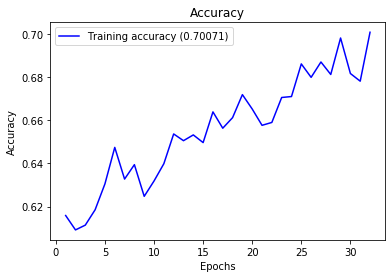

In [26]:
plot_history(m1)

In [27]:
new_model.save('milka_70_model_V3.h5')